In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import geopandas as gpd
from geopandas import GeoDataFrame
from shapely.geometry import Point
import skmob
from skmob import preprocessing

## Reading the DataFrame

### Data original

In [19]:
path = './DataGPS/Januari2022.csv'
df = pd.read_csv(path)
df = df.drop({'Unnamed: 0'},axis=1)
df.head()

/tmp/ipykernel_15516/2349169461.py:2: DtypeWarning: Columns (2,3,4) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(path)


,maid,latitude,longitude,timestamp
0,8f60c037-8ff2-4ccd-bd6d-05630f92550b,-7.677174,110.45501,1642378184
1,061fd420-fcd0-4923-8a2b-bbeee7c74872,-7.70582,110.31897,1642378196
2,061fd420-fcd0-4923-8a2b-bbeee7c74872,-7.705812,110.31898,1642378196
3,061fd420-fcd0-4923-8a2b-bbeee7c74872,-7.705812,110.31898,1642378220
4,b23130b2-1bdb-4f1d-b8b2-81d3204523c8,-7.84391,110.43813,1642378237


### Data reverse geocoding 

In [3]:
path2 = './DataGPS/RGjanuari2022.csv'
df2 = pd.read_csv(path2)
df2 = df2.drop({'Unnamed: 0'},axis=1)
df2.head()

,maid,latitude,longitude,datetime_wib,geometry,Kelurahan/Desa,Kecamatan,Kabupaten
0,de1cc960-90fe-46cb-91ae-eb08b27ebc37,-7.800000,110.300003,2022-01-01 00:00:00,POINT (110.3000030517578 -7.8),Balecatur,Gamping,Sleman
1,ee52276f-0886-40a1-ab70-b32ba57615a5,-7.830476,110.295151,2022-01-01 00:00:08,POINT (110.2951507568359 -7.8304763),Balecatur,Gamping,Sleman
2,6a1dbe26-eea5-4a6c-8445-13ab396db37d,-7.830476,110.295151,2022-01-01 00:00:48,POINT (110.2951507568359 -7.8304763),Balecatur,Gamping,Sleman
3,33ed0b90-7269-461f-ae28-f50599614361,-7.800000,110.300003,2022-01-01 00:01:17,POINT (110.3000030517578 -7.8),Balecatur,Gamping,Sleman
4,43e0d958-8833-47c6-a56d-7957fd2ba838,-7.800000,110.300003,2022-01-01 00:01:38,POINT (110.3000030517578 -7.8),Balecatur,Gamping,Sleman


In [4]:
# df2.iloc[df2['maid'] == '8f60c037-8ff2-4ccd-bd6d-05630f92550b', [0,1,2,3]]
# df.iloc[df['maid'] == '8f60c037-8ff2-4ccd-bd6d-05630f92550b']

## Mulai Preprocess

## 1. Filter Unnecessary Area
Membatasi area data point pada range yg dilakukan analisis

In [5]:
def filter_area(gps, road, filename):
    gps_path = gps
    road_path = road
    
    tdf = skmob.TrajDataFrame.from_file(gps_path)
    area_shape = gpd.read_file(road_path)
    tdf.to_dataframe()
    
    gdf_gps = GeoDataFrame(tdf, geometry=gpd.points_from_xy(tdf['longitude'], tdf['latitude']))
    filtered_data = gdf_gps[gdf_gps.geometry.within(area_shape.geometry.iloc[0])].copy()
    
    filtered_data['datetime_wib'] = pd.to_datetime(filtered_data['datetime_wib'])
    filtered_data['tanggal'] = filtered_data['datetime_wib'].dt.date
    
    filtered_data.to_csv(filename + '.csv', index=False)    

    filtered_data.info()
    # print(filtered_data.head())
    print("Filtering area for ", filename, "succeed")

In [6]:
gps = './DataGPS/RGnovember2021.csv'
road = './JaringanJalan/Malioboro/clipping_boundary.geojson'
filename ='filter1_malioboro_nov'
filter_area(gps, road, filename)

: 

In [23]:
data = pd.read_csv('./filter1_malioboro_jan.csv')
data['Kelurahan/Desa'].unique()

array(['Kelurahan Ngupasan', 'Kelurahan Gowongan',
       'Kelurahan Prawirodirjan', 'Kelurahan Suryatmajan',
       'Kelurahan Sosromenduran'], dtype=object)

## 2. Lihat persebaran data

In [4]:
def bar_chart(data):
    filtered_data = data.copy()

    # Hapus duplikat 'maid' berdasarkan tanggal
    filtered_data_unique_maid = filtered_data.drop_duplicates(subset=['tanggal', 'maid'])

    # Hitung jumlah unik per hari
    jumlah_unik_per_hari = filtered_data_unique_maid.groupby('tanggal').size()

    # Plotting
    plt.figure(figsize=(10, 6))
    jumlah_unik_per_hari.plot(kind='bar', color='skyblue')
    plt.title('Jumlah Data Maid unik per Hari')
    plt.xlabel('Tanggal')
    plt.ylabel('Jumlah Data Unik')
    plt.xticks(rotation=75)
    plt.show()

In [5]:
def count_maid(data):
    filtered_data = data.copy()
    
    # Ganti 'datetime_wib' sesuai nama kolom datetime di data-mu
    filtered_data['datetime_wib'] = pd.to_datetime(filtered_data['datetime_wib'])
    filtered_data['tanggal'] = filtered_data['datetime_wib'].dt.date

    # Hitung jumlah 'maid' unik per hari
    jumlah_maid_unik_per_hari = filtered_data.groupby('tanggal')['maid'].nunique()

    # Print hasilnya
    print(jumlah_maid_unik_per_hari)


In [33]:
def count_bykelurahan(data):
    filtered_data = data.copy()

    # Hitung jumlah 'maid' unik per hari
    jumlah_maid_unik = filtered_data.groupby('Kelurahan/Desa')['maid'].nunique()

    # Print hasilnya
    print(jumlah_maid_unik)


### Januari 2022

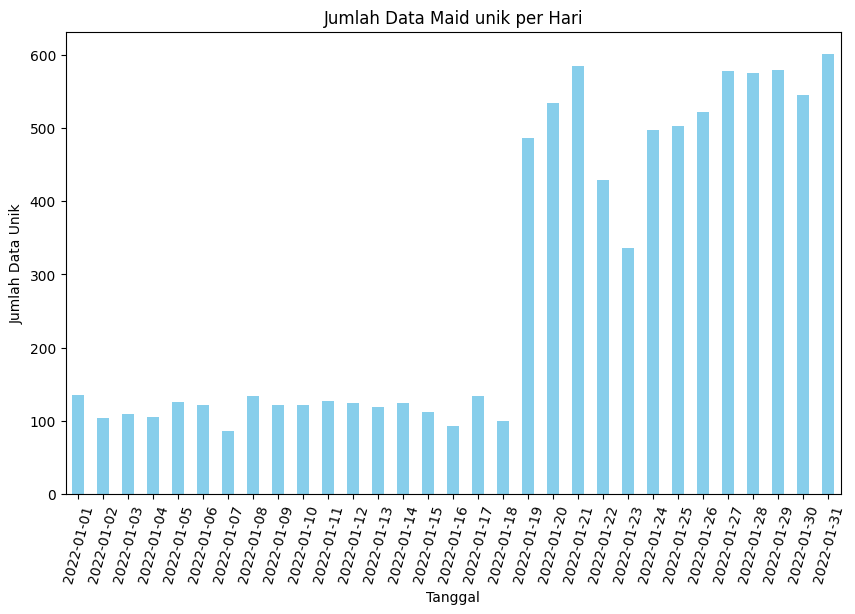

In [20]:
path = 'df2_filter1_jan.csv'
df2_filter1 = pd.read_csv(path)
df2_filter1 = df2_filter1.drop({'Unnamed: 0'},axis=1)
bar_chart(df2_filter1)

In [21]:
df2_filter1.info()
len(df2_filter1["maid"].unique())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 96729 entries, 0 to 96728
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   maid            96729 non-null  object 
 1   latitude        96729 non-null  float64
 2   longitude       96729 non-null  float64
 3   datetime_wib    96729 non-null  object 
 4   geometry        96729 non-null  object 
 5   Kelurahan/Desa  96729 non-null  object 
 6   Kecamatan       96729 non-null  object 
 7   Kabupaten       96729 non-null  object 
 8   tanggal         96729 non-null  object 
dtypes: float64(2), object(7)
memory usage: 6.6+ MB


4850

### Februari 2022

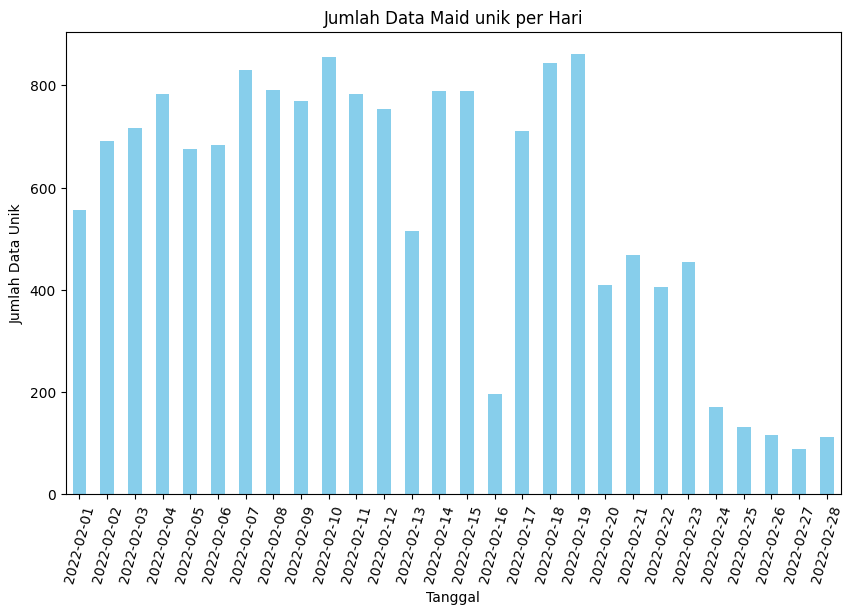

In [22]:
path = 'df2_filter1_feb.csv'
df2_filter1 = pd.read_csv(path)
df2_filter1 = df2_filter1.drop({'Unnamed: 0'},axis=1)
bar_chart(df2_filter1)

In [23]:
df2_filter1.info()
len(df2_filter1["maid"].unique())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244850 entries, 0 to 244849
Data columns (total 9 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   maid            244850 non-null  object 
 1   latitude        244850 non-null  float64
 2   longitude       244850 non-null  float64
 3   datetime_wib    244850 non-null  object 
 4   geometry        244850 non-null  object 
 5   Kelurahan/Desa  244850 non-null  object 
 6   Kecamatan       244850 non-null  object 
 7   Kabupaten       244850 non-null  object 
 8   tanggal         244850 non-null  object 
dtypes: float64(2), object(7)
memory usage: 16.8+ MB


7551

### Desember 2021

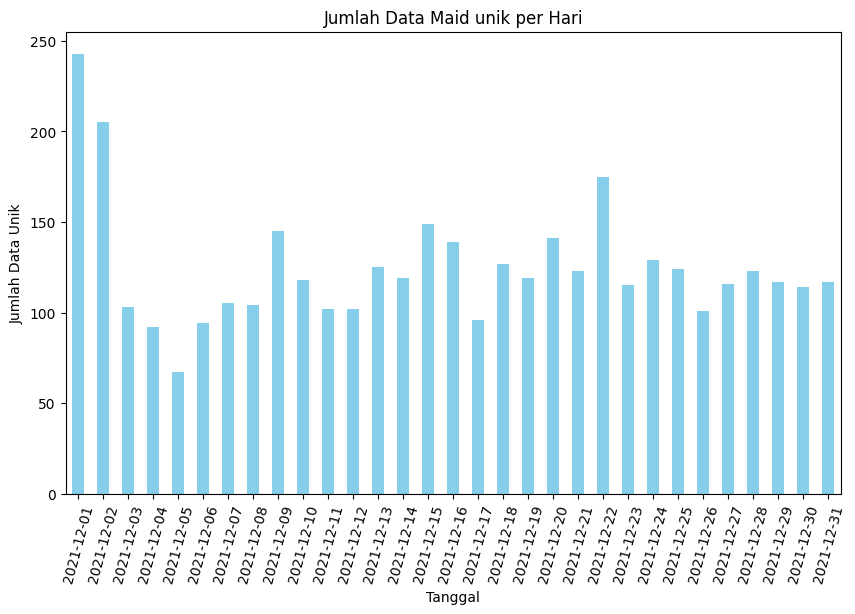

In [18]:
path = 'df2_filter1_des.csv'
df2_filter1 = pd.read_csv(path)
df2_filter1 = df2_filter1.drop({'Unnamed: 0'},axis=1)
bar_chart(df2_filter1)

In [19]:
df2_filter1.info()
len(df2_filter1["maid"].unique())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 111775 entries, 0 to 111774
Data columns (total 9 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   maid            111775 non-null  object 
 1   latitude        111775 non-null  float64
 2   longitude       111775 non-null  float64
 3   datetime_wib    111775 non-null  object 
 4   geometry        111775 non-null  object 
 5   Kelurahan/Desa  111775 non-null  object 
 6   Kecamatan       111775 non-null  object 
 7   Kabupaten       111775 non-null  object 
 8   tanggal         111775 non-null  object 
dtypes: float64(2), object(7)
memory usage: 7.7+ MB


2779

### November 2021

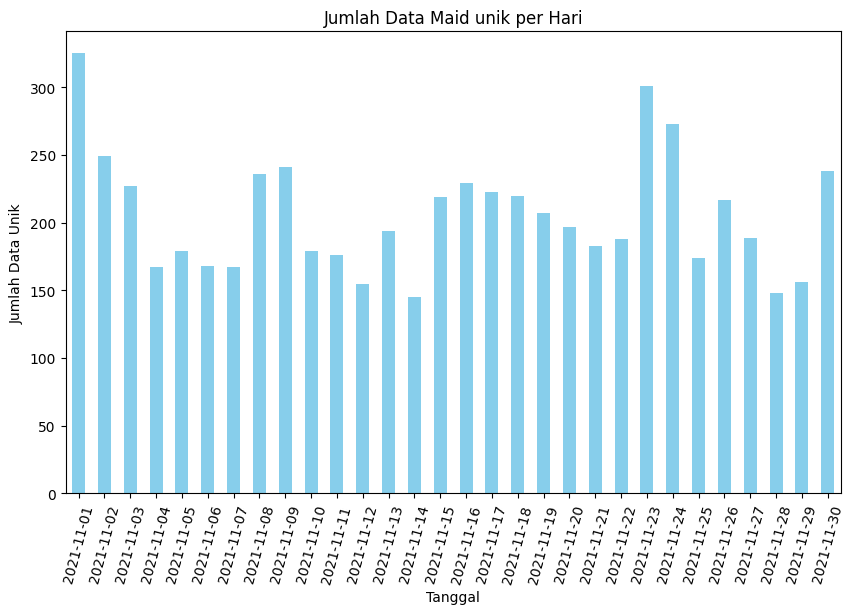

In [6]:
path = 'df2_filter1_nov.csv'
df2_filter1 = pd.read_csv(path)
df2_filter1 = df2_filter1.drop({'Unnamed: 0.1'},axis=1)
bar_chart(df2_filter1)

In [17]:
len(df2_filter1["maid"].unique())

3949

In [69]:
df2_filter1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 527286 entries, 0 to 527285
Data columns (total 9 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   maid            527286 non-null  object 
 1   latitude        527286 non-null  float64
 2   longitude       527286 non-null  float64
 3   datetime_wib    527286 non-null  object 
 4   geometry        527286 non-null  object 
 5   Kelurahan/Desa  527286 non-null  object 
 6   Kecamatan       527286 non-null  object 
 7   Kabupaten       527286 non-null  object 
 8   tanggal         527286 non-null  object 
dtypes: float64(2), object(7)
memory usage: 36.2+ MB


In [13]:
df2_filter1[df2_filter1["maid"] == '375bc2e5-1e09-4620-a780-c75d5a6aeb69']

,maid,latitude,longitude,datetime_wib,geometry,Kelurahan/Desa,Kecamatan,Kabupaten,tanggal
0,375bc2e5-1e09-4620-a780-c75d5a6aeb69,-7.775690,110.377663,2021-11-01 00:11:19,POINT (110.3776626586914 -7.77569),Caturtunggal,Depok,Sleman,2021-11-01
1,375bc2e5-1e09-4620-a780-c75d5a6aeb69,-7.775680,110.377647,2021-11-01 00:11:29,POINT (110.37764739990234 -7.77568),Caturtunggal,Depok,Sleman,2021-11-01
10,375bc2e5-1e09-4620-a780-c75d5a6aeb69,-7.775863,110.377472,2021-11-01 01:02:37,POINT (110.37747192382812 -7.775863),Caturtunggal,Depok,Sleman,2021-11-01
11,375bc2e5-1e09-4620-a780-c75d5a6aeb69,-7.775863,110.377472,2021-11-01 01:02:37,POINT (110.37747192382812 -7.775863),Caturtunggal,Depok,Sleman,2021-11-01
12,375bc2e5-1e09-4620-a780-c75d5a6aeb69,-7.775870,110.377472,2021-11-01 01:02:47,POINT (110.37747192382812 -7.77587),Caturtunggal,Depok,Sleman,2021-11-01
...,...,...,...,...,...,...,...,...,...
465963,375bc2e5-1e09-4620-a780-c75d5a6aeb69,-7.775890,110.377541,2021-11-28 22:17:47,POINT (110.3775405883789 -7.77589),Caturtunggal,Depok,Sleman,2021-11-28
465964,375bc2e5-1e09-4620-a780-c75d5a6aeb69,-7.775890,110.377541,2021-11-28 22:17:47,POINT (110.3775405883789 -7.77589),Caturtunggal,Depok,Sleman,2021-11-28
466388,375bc2e5-1e09-4620-a780-c75d5a6aeb69,-7.775794,110.377495,2021-11-29 23:44:24,POINT (110.37749481201172 -7.775794),Caturtunggal,Depok,Sleman,2021-11-29
466389,375bc2e5-1e09-4620-a780-c75d5a6aeb69,-7.775890,110.377518,2021-11-30 06:06:10,POINT (110.37751770019533 -7.77589),Caturtunggal,Depok,Sleman,2021-11-30
